This notebook performs a comparative analysis of uniformly processed enhancer calls across different MPRA/STARR-seq datasets. This analysis focus on comparing tested regions with different transcription levels and produces key results in Figure 5 and supplementary figure 6. 

In [1]:
# -------------------- Standard Library Imports --------------------
import argparse
import glob
import os
import sys
from multiprocessing import Pool, cpu_count
from random import sample
from subprocess import PIPE, Popen, STDOUT, call, run

# -------------------- Scientific Libraries ------------------------
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pybedtools
import pysam
import scipy
import statsmodels.stats.multitest as smm
from Bio import SeqIO

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# -------------------- PyBedTools Temp Directory -------------------
pybedtools.helpers.set_tempdir('/fs/cbsuhy02/storage/jz855/tmp/') 


In [2]:
# Specify root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)


/local/storage/jz855/STARR_seq_code/Final_Code_Sharing


In [3]:
def calculate_interval_overlaps(d1, d2):
    """
    Perform BEDTools intersection between two BedTool objects, keeping the number of overlapping base pairs.

    Args:
        d1 (BedTool): First interval set.
        d2 (BedTool): Second interval set.

    Returns:
        pd.DataFrame: Intersected intervals with overlap length as the last column.
    """
    # Perform intersection with base pair overlap information
    intersect = d1.intersect(d2, wo=True)
    intersect = intersect.to_dataframe(disable_auto_names=True, header=None)

    # Sort and remove duplicate entries from d1
    if len(intersect) > 0:
        intersect = intersect.sort_values(intersect.columns[-1], ascending=False)
        intersect = intersect.drop_duplicates([0, 1, 2, 3])  # deduplicate based on d1's key columns

    return intersect


def filter_by_minimum_overlap_bp(comp_df, bp_cutoff):
    """
    Filter overlaps to retain only those with at least a minimum base-pair overlap.

    Args:
        comp_df (pd.DataFrame): Overlap dataframe from `calculate_interval_overlaps`.
        bp_cutoff (int): Minimum number of base pairs required to retain the overlap.

    Returns:
        pd.DataFrame: Filtered dataframe.
    """
    if len(comp_df) > 0:
        df = comp_df[comp_df[12] >= bp_cutoff].copy()  # column 12 = number of overlapping bp
    else:
        df = pd.DataFrame(columns=[x for x in range(0, 13)] + ['pct_overlap_1', 'pct_overlap_2'])

    return df


def filter_by_minimum_overlap_pct(comp_df, pct_cutoff, reciprocal=True):
    """
    Filter overlaps based on minimum percentage overlap (reciprocal or not).

    Args:
        comp_df (pd.DataFrame): Overlap dataframe with percent overlap calculated.
        pct_cutoff (float): Minimum percent overlap to consider.
        reciprocal (bool): If True, require both overlaps to pass cutoff; if False, either.

    Returns:
        pd.DataFrame: Filtered dataframe.
    """
    if len(comp_df) > 0:
        if reciprocal:
            df = comp_df[
                (comp_df['pct_overlap_1'] >= pct_cutoff) & 
                (comp_df['pct_overlap_2'] >= pct_cutoff)
            ].copy()
        else:
            df = comp_df[
                (comp_df['pct_overlap_1'] >= pct_cutoff) | 
                (comp_df['pct_overlap_2'] >= pct_cutoff)
            ].copy()
    else:
        df = pd.DataFrame(columns=[x for x in range(0, 13)] + ['pct_overlap_1', 'pct_overlap_2'])

    return df


In [4]:
def compute_pairwise_overlap_stats(peak_1, tested_2):
    """
    Compute pairwise overlap statistics between two sets of genomic intervals.

    Parameters:
    -----------
    peak_1 : pd.DataFrame
        BED-like DataFrame representing the first set of regions.
        Expected columns include: ['chr', 'start', 'end', 'name', ..., 'length'] at column 4.

    tested_2 : pd.DataFrame
        BED-like DataFrame representing the second set of regions to compare against.
        Expected columns include: ['chr', 'start', 'end', 'name', ..., 'length'] at column 10.

    Returns:
    --------
    pd.DataFrame
        Intersected regions with:
        - overlap length (column 12)
        - percentage overlap relative to each input set (pct_overlap_1, pct_overlap_2)
        - best hit per peak_1 and peak_2 (based on maximum overlap)
    """
    peak_1 = peak_1.sort_values(['chr', 'start'])
    tested_2 = tested_2.sort_values(['chr', 'start'])

    peak_1_bed = pybedtools.BedTool.from_dataframe(peak_1)
    tested_2_bed = pybedtools.BedTool.from_dataframe(tested_2)
    
    peak_1_vs_tested_2 = calculate_interval_overlaps(peak_1_bed, tested_2_bed)

    # Retain the best (largest) overlap per region from peak_1 and tested_2
    comp_df = peak_1_vs_tested_2.sort_values(12, ascending=False)
    comp_df = comp_df.drop_duplicates([0, 1, 2, 3])  # keep one match per region in peak_1
    comp_df = comp_df.sort_values(12, ascending=False)
    comp_df = comp_df.drop_duplicates([6, 7, 8, 9])  # keep one match per region in tested_2

    # Compute overlap percentages relative to both sets
    comp_df['pct_overlap_1'] = comp_df[12] / comp_df[4] * 100
    comp_df['pct_overlap_2'] = comp_df[12] / comp_df[10] * 100

    return comp_df


def record_overlap_count(comp_df, call_df, tested_df, dataset_1, dataset_2):
    """
    Record the number of overlapping 'active' regions and total comparisons into matrices.

    Parameters:
    -----------
    comp_df : pd.DataFrame
        Overlap results for a dataset pair (from compute_pairwise_overlap_stats).

    call_df : pd.DataFrame
        Matrix to record the number of overlapping regions labeled as 'active'.

    tested_df : pd.DataFrame
        Matrix to record total number of overlapping regions tested.

    dataset_1 : str
        Name of the dataset for rows.

    dataset_2 : str
        Name of the dataset for columns.
    """
    call_df.loc[dataset_1, dataset_2] = len(comp_df[comp_df[11] == 'active'])
    tested_df.loc[dataset_1, dataset_2] = len(comp_df)


def compute_pairwise_peak_overlap(peak_df_list, tested_df_list, dataset_list):
    """
    Compute pairwise overlaps between multiple datasets and summarize overlap statistics.

    For each pairwise combination of datasets, this function:
    - Computes 1 bp overlaps (any overlap)
    - Computes 50% reciprocal overlaps
    - Records both total overlaps and active overlaps

    Parameters:
    -----------
    peak_df_list : list of pd.DataFrame
        List of active region dataframes from each dataset.

    tested_df_list : list of pd.DataFrame
        List of tested region dataframes for overlap comparison.

    dataset_list : list of str
        Names corresponding to each dataset (should match order of lists above).

    Returns:
    --------
    list of list of pd.DataFrame
        A nested list containing:
        - First sublist: [comp_df_1bp, comp_df_50pct_reciprocal]
            Matrices of counts of 'active' overlaps for 1bp and 50% reciprocal thresholds.
        - Second sublist: [tested_df_1bp, tested_df_50pct_reciprocal]
            Matrices of total overlaps (regardless of call) for the same thresholds.
    """
    # Initialize matrices for storing overlap counts
    comp_df_1bp = pd.DataFrame(columns=dataset_list, index=dataset_list)
    comp_df_50pct_reciprocal = pd.DataFrame(columns=dataset_list, index=dataset_list)

    tested_df_1bp = pd.DataFrame(columns=dataset_list, index=dataset_list)
    tested_df_50pct_reciprocal = pd.DataFrame(columns=dataset_list, index=dataset_list)

    # Perform all pairwise comparisons
    for i in range(len(peak_df_list)):
        for j in range(len(tested_df_list)):
            peak_1 = peak_df_list[i]
            tested_2 = tested_df_list[j]
            dataset_1 = dataset_list[i]
            dataset_2 = dataset_list[j]

            if i == j:
                # Diagonal: self-comparison
                comp_df_1bp.loc[dataset_1, dataset_2] = len(peak_1)
                comp_df_50pct_reciprocal.loc[dataset_1, dataset_2] = len(peak_1)
                tested_df_1bp.loc[dataset_1, dataset_2] = len(peak_1)
                tested_df_50pct_reciprocal.loc[dataset_1, dataset_2] = len(peak_1)
            else:
                # Compare dataset_1 against dataset_2
                comp_df = compute_pairwise_overlap_stats(peak_1, tested_2)

                # Filter for minimum 1bp overlap
                overlap_1bp = filter_by_minimum_overlap_bp(comp_df, bp_cutoff=1)
                record_overlap_count(overlap_1bp, comp_df_1bp, tested_df_1bp, dataset_1, dataset_2)

                # Filter for reciprocal 50% overlap
                overlap_50pct_reciprocal = filter_by_minimum_overlap_pct(comp_df, pct_cutoff=50, reciprocal=True)
                record_overlap_count(overlap_50pct_reciprocal, comp_df_50pct_reciprocal, tested_df_50pct_reciprocal, dataset_1, dataset_2)

    return [[comp_df_1bp, comp_df_50pct_reciprocal],
            [tested_df_1bp, tested_df_50pct_reciprocal]]



In [5]:
def generate_jaccard_index_matrices(dataset_list, overlap_matrices):
    """
    Generate Jaccard index matrices for a list of datasets using overlap statistics.

    This function calculates the Jaccard index for each pair of datasets, based on:
    Jaccard(A, B) = |A ∩ B| / |A ∪ B| 
                  = max(overlap_AB, overlap_BA) / (total_A + total_B - max(overlap_AB, overlap_BA))

    Parameters:
    -----------
    dataset_list : list of str
        Names of all datasets to be compared.

    overlap_matrices : list of list of pd.DataFrame
        A nested list of pairwise overlap matrices, as returned by `compute_pairwise_peak_overlap()`.
        Format:
            [
                [active_overlap_1bp, active_overlap_50pct],         # number of 'active' overlaps
                [total_tested_1bp, total_tested_50pct]              # number of total overlaps
            ]

    Returns:
    --------
    list of pd.DataFrame
        A list of Jaccard index matrices (one per overlap method), with dataset names as row/col labels.
        Order corresponds to the order of overlap strategies (1bp overlap, 50% reciprocal overlap).
    """
    jaccard_index_matrices = []

    for comp_df, tested_df in zip(*overlap_matrices):
        
        jaccard_df = pd.DataFrame(columns=dataset_list, index=dataset_list)
        
        for i in range(len(dataset_list)):
            for j in range(len(dataset_list)):
                
                dataset_1 = dataset_list[i]
                dataset_2 = dataset_list[j]
                
                if i == j:
                    # Diagonal is not meaningful for Jaccard index
                    jaccard_df.loc[dataset_1, dataset_2] = 0
                else:
                    # Total number of tested regions per dataset
                    tested_1 = tested_df.loc[dataset_1, dataset_2]
                    tested_2 = tested_df.loc[dataset_2, dataset_1]
                    
                    # Number of overlapping active regions (use max of A->B and B->A)
                    active_1 = comp_df.loc[dataset_1, dataset_2]
                    active_2 = comp_df.loc[dataset_2, dataset_1]
                    num_active = np.max([active_1, active_2])

                    # Compute Jaccard index
                    jaccard_value = num_active / (tested_1 + tested_2 - num_active)
                    
                    # Fill in symmetric matrix
                    jaccard_df.loc[dataset_1, dataset_2] = jaccard_value
                    jaccard_df.loc[dataset_2, dataset_1] = jaccard_value
            
        jaccard_index_matrices.append(jaccard_df)

    return jaccard_index_matrices


In [6]:
def perform_overlap_analysis(lentimpra_peak, atac_starr_peak, whg_starr_peak,
                             lentimpra, atac_starr, whg_starr):
    """
    Prepares cleaned peak/tested region DataFrames and computes overlap and Jaccard index matrices
    for three datasets: LentiMPRA, ATAC-STARR-seq, and WHG-STARR-seq.
    
    Returns:
        all_overlap_summary_matrices (list): Pairwise overlap matrices (1bp and 50%).
        all_jaccard_index_matrices (list): Pairwise Jaccard index matrices.
    """
    # -------------------------------------------
    # Set plot title strings for overlap metrics
    # -------------------------------------------
    overlap_titles = {
        '1bp': 'Overlap ' + u'$\geq$ ' + '1bp',
        '50pct': 'Reciprocal Overlap ' + u'$\geq$ ' + '50%'
    }

    # -------------------------------------------
    # Prepare peak DataFrames for each dataset
    # -------------------------------------------
    peak_df_list = [
        lentimpra_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
        atac_starr_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
        whg_starr_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end'])
    ]

    tested_df_list = [
        lentimpra[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
        atac_starr[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
        whg_starr[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end'])
    ]

    dataset_list = ['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq']

    # -------------------------------------------
    # Compute pairwise peak overlaps:
    # [0] = 1bp overlap, [1] = 50% reciprocal overlap
    # -------------------------------------------
    all_overlap_summary_matrices = compute_pairwise_peak_overlap(peak_df_list, tested_df_list, dataset_list)

    # -------------------------------------------
    # Compute Jaccard index matrices based on overlaps
    # -------------------------------------------
    all_jaccard_index_matrices = generate_jaccard_index_matrices(dataset_list, all_overlap_summary_matrices)

    return (all_overlap_summary_matrices, all_jaccard_index_matrices)



In [7]:
def plot_overlap_percentage_heatmap(df_call, df_tested, title, output_file=''):
    """
    Plot a detailed heatmap showing overlap counts and percentages between datasets.

    For each pair of datasets, this function computes the percentage of overlapping elements
    (active/positive calls) out of total tested regions, and creates a heatmap with counts and percentages.

    Parameters:
    -----------
    df_call : pd.DataFrame
        A matrix of overlapping region counts (e.g., number of active overlaps).
        Rows and columns should be dataset names.

    df_tested : pd.DataFrame
        A matrix of total tested region counts (denominator for percentage calculations).
        Same shape and labels as `df_call`.

    title : str
        Title to display on the heatmap.

    output_file : str, optional
        Path to save the heatmap figure (PNG/PDF/etc). If empty, figure is not saved.

    Returns:
    --------
    None
    """

    # -----------------------------------
    # Step 1: Compute percent overlap matrix
    # -----------------------------------
    df_pct = pd.DataFrame(columns=df_call.columns.tolist(), index=df_call.columns.tolist())

    for i in range(len(df_call.columns)):
        for j in range(len(df_call.columns)):
            row = df_call.columns[i]
            col = df_call.columns[j]

            if df_tested.loc[row, col] > 0:
                df_pct.loc[row, col] = df_call.loc[row, col] / df_tested.loc[row, col] * 100
            else:
                df_pct.loc[row, col] = 0.00

    # -----------------------------------
    # Step 2: Create annotated heatmap labels
    # -----------------------------------
    annot = df_pct.applymap("{0:.2f}%".format)

    for row in annot.index:
        for col in annot.columns:
            if row == col:
                annot.loc[row, col] = "{:,}".format(int(df_call.loc[row, col])) + '\n' + annot.loc[row, col]
            else:
                annot.loc[row, col] = (
                    "{:,}".format(int(df_call.loc[row, col])) + '/' +
                    "{:,}".format(int(df_tested.loc[row, col])) + '\n' + annot.loc[row, col]
                )

    df_pct = df_pct.astype(float)

    # -----------------------------------
    # Step 3: Plot heatmap using seaborn
    # -----------------------------------
    fig = plt.figure(figsize=(12 / 5 * len(df_call), 12 / 5 * len(df_call)))
    sns.set_style(style='white')

    cmap = 'YlOrBr'
    ax = sns.heatmap(
        df_pct,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        vmin=0,
        vmax=100,
        annot=annot,
        annot_kws={"fontsize": 17},
        fmt='',
        cbar=True
    )

    # Configure tick positions and labels
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    tick_labels = df_pct.columns.tolist()
    ax.set_xticklabels(tick_labels, fontsize=17, rotation=90)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels, rotation=0, fontsize=17, va="center")

    # Set title
    ax.set_title(title, fontsize=20)

    # Format colorbar ticks as percentages
    cbar = ax.collections[0].colorbar
    yticklabel = [t.get_text() for t in cbar.ax.get_yticklabels()]
    cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
    cbar.ax.tick_params(labelsize=17)

    # -----------------------------------
    # Step 4: Save or display figure
    # -----------------------------------
    if output_file != '':
        plt.savefig(output_file, bbox_inches='tight', transparent=True, dpi=300)
        

In [8]:
def plot_jaccard_index_heatmap(df_jaccard, title, output_file=''):
    """
    Plot a heatmap of Jaccard indices to visualize pairwise similarity between datasets.

    This function plots a symmetric matrix where each cell represents the Jaccard index
    (i.e., intersection / union) of overlapping elements between two datasets.
    Only the lower triangle of the matrix is shown (to avoid redundancy).

    Parameters:
    -----------
    df_jaccard : pd.DataFrame
        A square DataFrame containing Jaccard index values between all pairs of datasets.
        Rows and columns should be dataset names.

    title : str
        Title of the plot.

    output_file : str, optional
        If provided, the heatmap is saved to this path.

    Returns:
    --------
    None
    """

    # Format each value as string with 2 decimal points
    annot = df_jaccard.applymap("{0:.2f}".format)

    # Ensure numeric type for plotting
    df_jaccard = df_jaccard.astype(float)

    # Mask upper triangle to keep only lower half (since matrix is symmetric)
    mask = np.triu(np.ones_like(df_jaccard, dtype=bool))

    # -------------------------------------------
    # Plot Setup
    # -------------------------------------------
    fig = plt.figure(figsize=(8 / 5 * len(df_jaccard), 8 / 5 * len(df_jaccard)))
    sns.set_style(style='white')

    cmap = 'YlOrBr'  # Yellow to Orange to Brown colormap

    # Draw heatmap
    ax = sns.heatmap(
        df_jaccard,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        vmin=0,
        vmax=1,
        annot=annot,
        annot_kws={"fontsize": 17},
        fmt='',
        cbar=True,
        mask=mask  # only show lower triangle
    )

    # Set axis tick positions
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Format axis labels
    tick = df_jaccard.columns.tolist()
    ax.set_xticklabels(tick, fontsize=17, rotation=90)
    plt.yticks(np.arange(len(tick)) + 0.5, tick, rotation=0, fontsize=17, va="center")

    # Title
    ax.set_title(title, fontsize=20)

    # Format colorbar tick labels
    cbar = ax.collections[0].colorbar
    yticklabel = [t.get_text() for t in cbar.ax.get_yticklabels()]
    cbar.ax.set_yticklabels(['{:.2f}'.format(float(x)) for x in yticklabel], fontsize=17)
    cbar.ax.tick_params(labelsize=17)

    # Save to file if output path is provided
    if output_file != '':
        plt.savefig(output_file, bbox_inches='tight', transparent=True, dpi=300)
        

In [9]:
# Columns

columns = ['chr', 'start', 'end', 'name', 'logFC', 'strand', 'z_score', 'size', 'call', 
 'forward_raw', 'reverse_raw', 'total_raw', 'forward_signal', 'reverse_signal', 'total_signal', 
 'gro_chr', 'gro_start', 'gro_end', 'gro_type', 'gro_size', 'gro_overlap_bp', 'gro_overlap_pct_region', 'gro_overlap_pct_GROcap_element', 
 'ccre_chr', 'ccre_start', 'ccre_end', 'ccre_name', 'ccre_type', 'ccre_size', 'ccre_overlap_bp', 'ccre_overlap_pct_region', 'ccre_overlap_pct_ccre', 
 'promoter_400bp_tss', 'promoter_1kb_tss', 'promoter_4kb_tss', 
 'separate_GROcap_signal_levels', 'binary_transcription_class', 
 'divergent', 'unidirectional', 'bidirectional', 'not_overlap_GROcap_elements', 
 'CA_CTCF', 'CA_H3K4me3', 'CA_TF', 'dELS', 'pELS', 'Low_DNase', 'PLS', 'CA_only', 'not_overlap_cCRE', 
 'ELS', 'ELS_PLS']

print(len(columns))


52


In [10]:
# -------------------------------------------
# Set plot title strings for overlap metrics
# -------------------------------------------
overlap_1bp_title_prefix = 'Overlap ' + u'$\geq$ ' + '1bp'
reciprocal_50pct_title_prefix = 'Reciprocal Overlap ' + u'$\geq$ ' + '50%'


# Load data

In [11]:
# Load dataset, orientation-independent calls

# Only LentiMPRA, ATAC-STARR-seq and WHG-STARR-seq 

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'LentiMPRA', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
lentimpra_all = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(lentimpra_all))
lentimpra_all.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'ATAC_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
atac_starr_all = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(atac_starr_all))
atac_starr_all.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'WHG_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
whg_starr_all = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(whg_starr_all))
whg_starr_all.columns = columns



109506
304682
1622172


In [12]:
# check

print(lentimpra_all.groupby(['call']).size())

print(atac_starr_all.groupby(['call']).size())

print(whg_starr_all.groupby(['call']).size())



call
active      26870
inactive    82636
dtype: int64
call
active       11507
inactive    293175
dtype: int64
call
active        25274
inactive    1596898
dtype: int64


In [13]:
# subset peaks

lentimpra_peak_all = lentimpra_all[lentimpra_all['call'] == 'active']
print(len(lentimpra_peak_all))

atac_starr_peak_all = atac_starr_all[atac_starr_all['call'] == 'active']
print(len(atac_starr_peak_all))

whg_starr_peak_all = whg_starr_all[whg_starr_all['call'] == 'active']
print(len(whg_starr_peak_all))


26870
11507
25274


# Compare all regions with no transcription

In [14]:
# ----------------------------------------------
# Subset Assay Data for Regions with No Transcriptional Activity
# ----------------------------------------------
# Filter both peak and tested region data where GRO-cap signal indicates no transcription
# This focuses the analysis on regions that are functionally tested but transcriptionally silent.

# Subset LentiMPRA peaks and tested regions
lentimpra_peak = lentimpra_peak_all[lentimpra_peak_all['separate_GROcap_signal_levels'] == 'none_transcription']
lentimpra = lentimpra_all[lentimpra_all['separate_GROcap_signal_levels'] == 'none_transcription']

# Subset ATAC-STARR peaks and tested regions
atac_starr_peak = atac_starr_peak_all[atac_starr_peak_all['separate_GROcap_signal_levels'] == 'none_transcription']
atac_starr = atac_starr_all[atac_starr_all['separate_GROcap_signal_levels'] == 'none_transcription']

# Subset WHG-STARR peaks and tested regions
whg_starr_peak = whg_starr_peak_all[whg_starr_peak_all['separate_GROcap_signal_levels'] == 'none_transcription']
whg_starr = whg_starr_all[whg_starr_all['separate_GROcap_signal_levels'] == 'none_transcription']


<ipython-input-7-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-7-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)


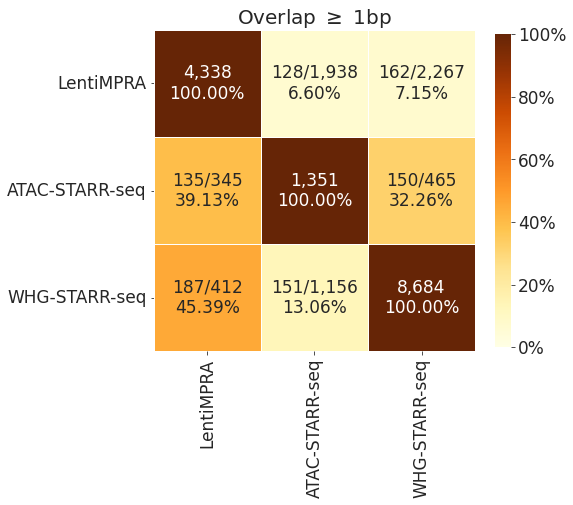

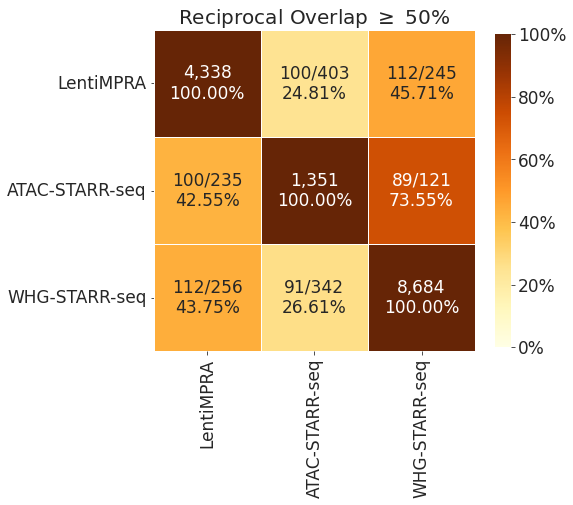

In [15]:
all_none_overlap_summary_matrices, all_none_jaccard_index_matrices = perform_overlap_analysis(lentimpra_peak, atac_starr_peak, whg_starr_peak,
                                                                                           lentimpra, atac_starr, whg_starr)
# 1bp overlap: counts + %
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'none', 'all_no_transcription_overlap_1bp.pdf')
plot_overlap_percentage_heatmap(all_none_overlap_summary_matrices[0][0], all_none_overlap_summary_matrices[1][0], overlap_1bp_title_prefix, out_path)

# 50% reciprocal overlap: counts + %
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'none', 'all_no_transcription_reciprocal_overlap_50pct.pdf')
plot_overlap_percentage_heatmap(all_none_overlap_summary_matrices[0][1], all_none_overlap_summary_matrices[1][1], reciprocal_50pct_title_prefix, out_path)


# Compare all regions with low transcription

In [16]:
# ----------------------------------------------
# Subset Assay Data for Regions with No Transcriptional Activity
# ----------------------------------------------
# Filter both peak and tested region data where GRO-cap signal indicates no transcription
# This focuses the analysis on regions that are functionally tested but transcriptionally silent.

# Subset LentiMPRA peaks and tested regions
lentimpra_peak = lentimpra_peak_all[lentimpra_peak_all['separate_GROcap_signal_levels'] == 'low_transcription']
lentimpra = lentimpra_all[lentimpra_all['separate_GROcap_signal_levels'] == 'low_transcription']

# Subset ATAC-STARR peaks and tested regions
atac_starr_peak = atac_starr_peak_all[atac_starr_peak_all['separate_GROcap_signal_levels'] == 'low_transcription']
atac_starr = atac_starr_all[atac_starr_all['separate_GROcap_signal_levels'] == 'low_transcription']

# Subset WHG-STARR peaks and tested regions
whg_starr_peak = whg_starr_peak_all[whg_starr_peak_all['separate_GROcap_signal_levels'] == 'low_transcription']
whg_starr = whg_starr_all[whg_starr_all['separate_GROcap_signal_levels'] == 'low_transcription']



<ipython-input-7-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-7-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)


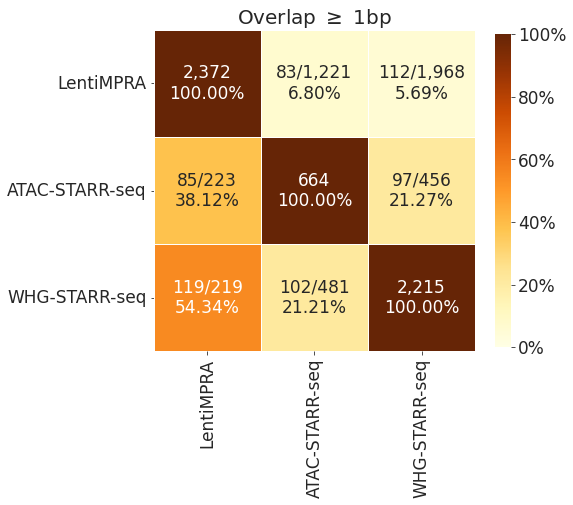

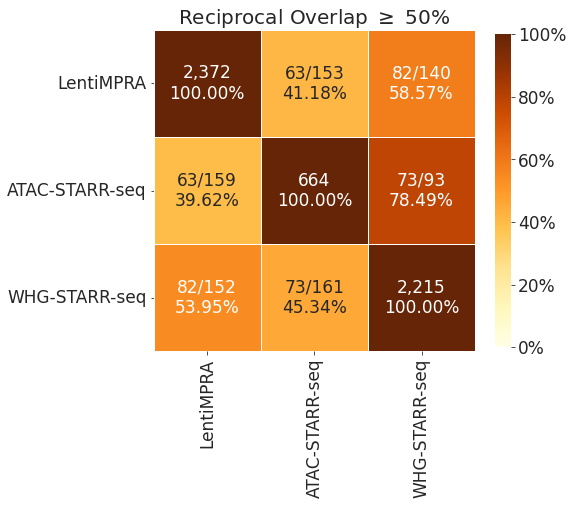

In [17]:
all_low_overlap_summary_matrices, all_low_jaccard_index_matrices = perform_overlap_analysis(lentimpra_peak, atac_starr_peak, whg_starr_peak,
                                                                                           lentimpra, atac_starr, whg_starr)
# 1bp overlap: counts + %
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'low', 'all_low_transcription_overlap_1bp.pdf')
plot_overlap_percentage_heatmap(all_low_overlap_summary_matrices[0][0], all_low_overlap_summary_matrices[1][0], overlap_1bp_title_prefix, out_path)

# 50% reciprocal overlap: counts + %
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'low', 'all_low_transcription_reciprocal_overlap_50pct.pdf')
plot_overlap_percentage_heatmap(all_low_overlap_summary_matrices[0][1], all_low_overlap_summary_matrices[1][1], reciprocal_50pct_title_prefix, out_path)


# Compare all regions with medium transcription

In [18]:
# ----------------------------------------------
# Subset Assay Data for Regions with No Transcriptional Activity
# ----------------------------------------------
# Filter both peak and tested region data where GRO-cap signal indicates no transcription
# This focuses the analysis on regions that are functionally tested but transcriptionally silent.

# Subset LentiMPRA peaks and tested regions
lentimpra_peak = lentimpra_peak_all[lentimpra_peak_all['separate_GROcap_signal_levels'] == 'medium_transcription']
lentimpra = lentimpra_all[lentimpra_all['separate_GROcap_signal_levels'] == 'medium_transcription']

# Subset ATAC-STARR peaks and tested regions
atac_starr_peak = atac_starr_peak_all[atac_starr_peak_all['separate_GROcap_signal_levels'] == 'medium_transcription']
atac_starr = atac_starr_all[atac_starr_all['separate_GROcap_signal_levels'] == 'medium_transcription']

# Subset WHG-STARR peaks and tested regions
whg_starr_peak = whg_starr_peak_all[whg_starr_peak_all['separate_GROcap_signal_levels'] == 'medium_transcription']
whg_starr = whg_starr_all[whg_starr_all['separate_GROcap_signal_levels'] == 'medium_transcription']


<ipython-input-7-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-7-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)


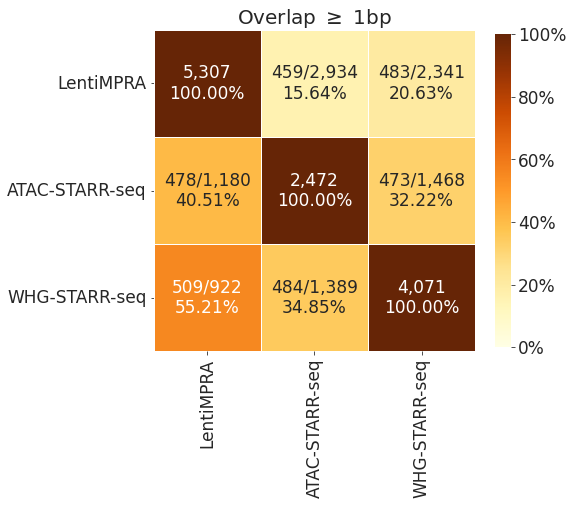

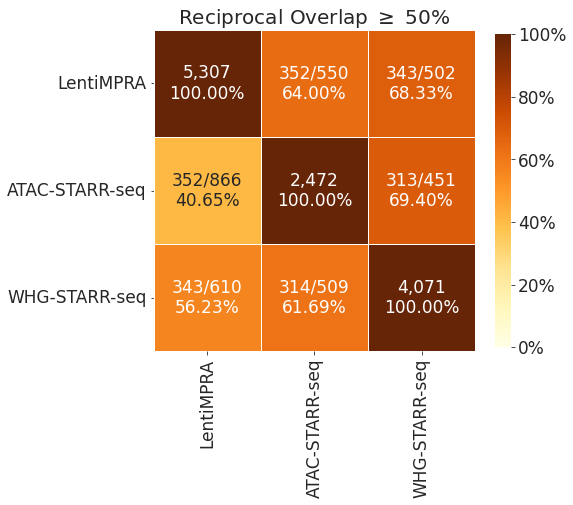

In [19]:
all_medium_overlap_summary_matrices, all_medium_jaccard_index_matrices = perform_overlap_analysis(lentimpra_peak, atac_starr_peak, whg_starr_peak,
                                                                                           lentimpra, atac_starr, whg_starr)
# 1bp overlap: counts + %
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'medium', 'all_medium_transcription_overlap_1bp.pdf')
plot_overlap_percentage_heatmap(all_medium_overlap_summary_matrices[0][0], all_medium_overlap_summary_matrices[1][0], overlap_1bp_title_prefix, out_path)

# 50% reciprocal overlap: counts + %
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'medium', 'all_medium_transcription_reciprocal_overlap_50pct.pdf')
plot_overlap_percentage_heatmap(all_medium_overlap_summary_matrices[0][1], all_medium_overlap_summary_matrices[1][1], reciprocal_50pct_title_prefix, out_path)


# Compare all regions with high transcription

In [20]:
# ----------------------------------------------
# Subset Assay Data for Regions with No Transcriptional Activity
# ----------------------------------------------
# Filter both peak and tested region data where GRO-cap signal indicates no transcription
# This focuses the analysis on regions that are functionally tested but transcriptionally silent.

# Subset LentiMPRA peaks and tested regions
lentimpra_peak = lentimpra_peak_all[lentimpra_peak_all['separate_GROcap_signal_levels'] == 'high_transcription']
lentimpra = lentimpra_all[lentimpra_all['separate_GROcap_signal_levels'] == 'high_transcription']

# Subset ATAC-STARR peaks and tested regions
atac_starr_peak = atac_starr_peak_all[atac_starr_peak_all['separate_GROcap_signal_levels'] == 'high_transcription']
atac_starr = atac_starr_all[atac_starr_all['separate_GROcap_signal_levels'] == 'high_transcription']

# Subset WHG-STARR peaks and tested regions
whg_starr_peak = whg_starr_peak_all[whg_starr_peak_all['separate_GROcap_signal_levels'] == 'high_transcription']
whg_starr = whg_starr_all[whg_starr_all['separate_GROcap_signal_levels'] == 'high_transcription']



<ipython-input-7-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-7-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)


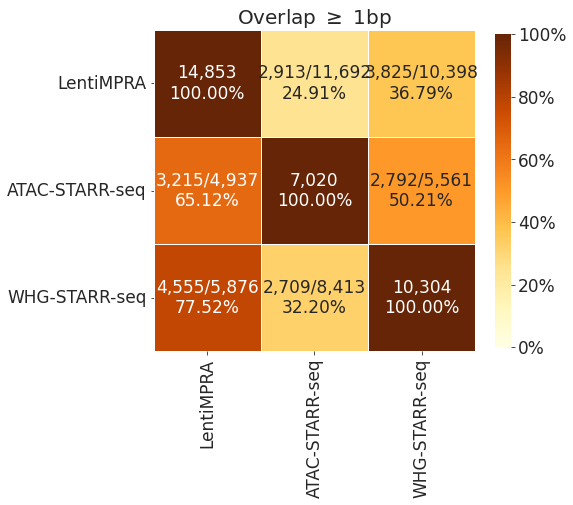

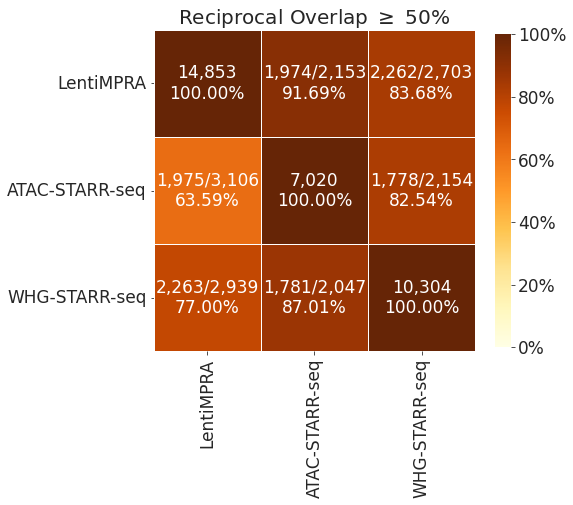

In [21]:
all_high_overlap_summary_matrices, all_high_jaccard_index_matrices = perform_overlap_analysis(lentimpra_peak, atac_starr_peak, whg_starr_peak,
                                                                                           lentimpra, atac_starr, whg_starr)
# 1bp overlap: counts + %
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'high', 'all_high_transcription_overlap_1bp.pdf')
plot_overlap_percentage_heatmap(all_high_overlap_summary_matrices[0][0], all_high_overlap_summary_matrices[1][0], overlap_1bp_title_prefix, out_path)

# 50% reciprocal overlap: counts + %
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'high', 'all_high_transcription_reciprocal_overlap_50pct.pdf')
plot_overlap_percentage_heatmap(all_high_overlap_summary_matrices[0][1], all_high_overlap_summary_matrices[1][1], reciprocal_50pct_title_prefix, out_path)


# Compare Jaccard Index altegother

In [22]:

def reformat_jaccard_index_data(jaccard_df, overlap_type, comparison_type):
    """
    Reformats a square Jaccard index matrix into a long-format DataFrame for easier downstream analysis.

    Parameters:
    - jaccard_df (pd.DataFrame): Square matrix of Jaccard index values with rows/columns as dataset labels.
    - overlap_type (str): Type of overlap used for comparison (e.g., "overlap_1bp", "reciprocal_50pct").
    - comparison_type (str): Category of comparison (e.g., "all", "distal", "proximal").

    Returns:
    - pd.DataFrame: Long-format DataFrame with columns:
        ['comparison', 'jaccard_index', 'overlap_type', 'comp_type']
    """
    reformatted_data = []

    for row_label in jaccard_df.index:
        for col_label in jaccard_df.columns:
            if row_label == col_label:
                continue  # Skip self-comparisons
            comparison_label = ' vs. '.join(sorted([row_label, col_label]))
            jaccard_value = jaccard_df.loc[row_label, col_label]
            reformatted_data.append([comparison_label, jaccard_value, overlap_type, comparison_type])

    # Convert to DataFrame and remove duplicate (symmetric) comparisons
    reformatted_df = pd.DataFrame(
        reformatted_data,
        columns=['comparison', 'jaccard_index', 'overlap_type', 'comp_type']
    ).drop_duplicates()

    return reformatted_df



In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

color_palette = ['#fdabab', '#c8edeb', '#cee3f6']

def plot_jaccard_index_by_transcription_level(
    df, 
    transcription_order, 
    transcription_labels, 
    plot_title, 
    palette=color_palette, 
    output_path='', 
    log_scale=True,
    legend=True
):
    # Ensure a style that actually draws ticks
    sns.set_theme(style="ticks")  # key line

    fig = plt.figure(figsize=(1.2 * len(transcription_order), 4))

    ax = sns.pointplot(
        data=df,
        x="comp_type",
        y="jaccard_index",
        hue="comparison",
        palette=palette,
        order=transcription_order,
        errorbar=None,
        linewidth=3
    )

    # If ticks were globally disabled, force-enable them
    ax.tick_params(axis='x', which='both', bottom=True, top=False, length=6, width=1)
    ax.tick_params(axis='y', which='both', left=True, right=False, length=6, width=1)
    ax.xaxis.set_ticks(range(len(transcription_order)))
    ax.set_xticklabels(transcription_labels, rotation=30)

    # Optional: if they still don't show, comment out despine
    # sns.despine()

    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('Transcription Level', fontsize=17)
    ax.set_ylabel('Jaccard Index ($log_{10}$)' if log_scale else 'Jaccard Index (JI)', fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    if legend:
        sns.move_legend(
            ax, loc='upper left',
            bbox_to_anchor=(1, 1),
            frameon=False,
            fontsize=13,
            title=''
        )

    plt.title(plot_title, fontsize=20, x=0.5, y=1.1)
    sns.despine()

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', transparent=True, dpi=300)

    plt.show()

In [37]:
# --------------------------------------------------------
# Reformat all Jaccard index matrices across transcription levels and overlap types
# --------------------------------------------------------

# Initialize list to store reformatted DataFrames
reformatted_df_list = []

# Define the input matrices for each transcription level
jaccard_matrix_list_by_transcription = [
    all_none_jaccard_index_matrices,
    all_low_jaccard_index_matrices,
    all_medium_jaccard_index_matrices,
    all_high_jaccard_index_matrices
]

# Define the corresponding transcription level labels
transcription_level_labels = [
    'no_transcription',
    'low_transcription',
    'medium_transcription',
    'high_transcription'
]

# Define the two types of overlap comparisons
overlap_types = ['overlap_1bp', 'reciprocal_overlap_50pct']

# Loop over each transcription level and corresponding Jaccard matrices
for jaccard_matrices, transcription_label in zip(jaccard_matrix_list_by_transcription, transcription_level_labels):
    for jaccard_df, overlap_label in zip(jaccard_matrices, overlap_types):
        # Reformat the matrix and append it to the list
        reformatted_df = reformat_jaccard_index_data(
            jaccard_df, overlap_label, transcription_label
        )
        reformatted_df_list.append(reformatted_df)

# Output number of reformatted dataframes
print(f"Total reformatted matrices: {len(reformatted_df_list)}")

# Combine all reformatted data into a single DataFrame
all_jaccard_df = pd.concat(reformatted_df_list, axis=0, ignore_index=True)

# Display the combined DataFrame
all_jaccard_df.head()



Total reformatted matrices: 8


,comparison,jaccard_index,overlap_type,comp_type
0,ATAC-STARR-seq vs. LentiMPRA,0.062849,overlap_1bp,no_transcription
1,LentiMPRA vs. WHG-STARR-seq,0.075040,overlap_1bp,no_transcription
2,ATAC-STARR-seq vs. WHG-STARR-seq,0.102721,overlap_1bp,no_transcription
3,ATAC-STARR-seq vs. LentiMPRA,0.185874,reciprocal_overlap_50pct,no_transcription
4,LentiMPRA vs. WHG-STARR-seq,0.287918,reciprocal_overlap_50pct,no_transcription


In [38]:
# Save
out_path = os.path.join(project_root, 'output', 'compare_across_assays', 'reformatted_jaccard_df_all_uniform_processed_by_transcription_levels.txt')
all_jaccard_df.to_csv(out_path, sep='\t', header=True, index=False)
print('finished')


finished


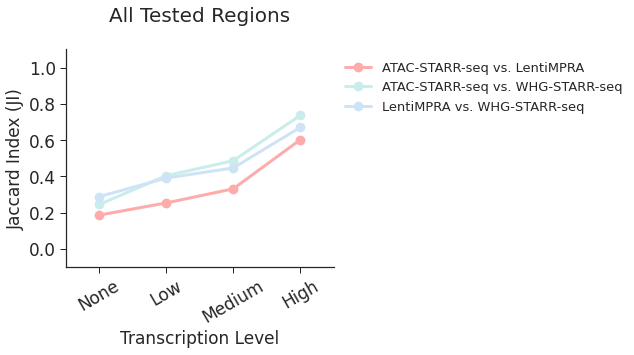

In [43]:
out_path = os.path.join(project_root, 'plot', 'compare_uniform_processed_enhancer_calls', 'different_transcription_level', 'jaccard_index_pointplot.pdf')
plot_jaccard_index_by_transcription_level(
    df = all_jaccard_df[all_jaccard_df['overlap_type'] == 'reciprocal_overlap_50pct'].sort_values('comparison'), 
    transcription_order = ['no_transcription', 'low_transcription', 'medium_transcription', 'high_transcription'], 
    transcription_labels= ['None', 'Low', 'Medium', 'High'], 
    plot_title='All Tested Regions', output_path=out_path, log_scale=False)


